In [1]:
import numpy as np
from pydci import Model
from pydci.log import enable_log
from  pydci import SequentialMUDProblem
from pydci.examples.lotka_volterra import run_lv, lv_p1, lv_p2, lv_param_mins
import matplotlib.pyplot as plt
import importlib

enable_log()

[04/06/23 17:42:53] INFO     Logger initialized                                                           ]8;id=895511;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/log.py\log.py]8;;\:]8;id=321855;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/log.py#35\35]8;;\

<loguru.logger handlers=[(id=1, level=20, sink=<RichHandler (NOTSET)>)]>

# Lotka-Volter Model

In [2]:
importlib.reload(SequentialMUDProblem)
importlib.reload(Model)

lv1_true_param = lv_p1
x0 = [2, 4]
param_shifts = None  # {17: lv_p2}

lvm_model = Model.DynamicModel(
    run_lv,
    x0,
    lv1_true_param,
    measurement_noise=0.1,
    solve_ts=0.3,
    sample_ts=1,
    diff=0.5,
    param_mins=lv_param_mins,
    param_shifts=param_shifts,
)

## First iteration

In [3]:
args = lvm_model.mud_args(10, num_samples=1000)
lvm_model.x0, lvm_model.t0, args['data'].shape

[04/06/23 17:42:58] INFO     Drawing 1000 from uniform at:                                             ]8;id=878901;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=58544;file:///home/jupyter/MyData/repos/pyDCI/src/pydci/Model.py#250\250]8;;\
                                     loc: [0.55 0.2  0.25 0.05]                                                    
                                     scale: [1.1 0.4 0.5 0.1]                                                      

Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.6s (1753.


(array([1.78121444, 3.59713918]), 9.375, (22, 1))

### Linear Search

In [11]:
importlib.reload(SequentialMUDProblem)

seq_mud_prob = SequentialMUDProblem.SequentialMUDProblem(
    *[args[x] for x in ['samples', 'q_lam', 'data', 'std_dev']],
    max_nc=args['max_nc'], qoi_method='linear', best_method='max_kl')
seq_mud_prob.solve()

In [12]:
seq_mud_prob.result

,,nc,lam_MUD_0,lam_MUD_1,lam_MUD_2,lam_MUD_3,e_r,kl,predict_delta,within_thresh,closest,max_kl,min_kl,action
12,1,2.0,1.597867,0.571076,0.393396,0.080497,0.599284,6.865696,0.400716,True,False,True,False,UPDATE


In [13]:
seq_mud_prob.results

nc  lam_MUD_0  lam_MUD_1  lam_MUD_2  lam_MUD_3           e_r        kl  \
0  0  1.0   1.103631   0.429548   0.456629   0.079672  1.041438e+00  0.873629   
   1  2.0   0.770058   0.298327   0.625757   0.082330  1.074119e+00  1.532361   
   2  3.0   1.460760   0.545204   0.496091   0.113643  9.796681e-01  1.927679   
   3  4.0   1.176738   0.448133   0.463705   0.085794  8.420648e-01  2.605484   
1  0  1.0   0.745196   0.375298   0.648617   0.080918  9.551225e-01  1.929409   
...   ...        ...        ...        ...        ...           ...       ...   
16 3  4.0   1.269163   0.461683   0.419648   0.086840  4.081854e-41  6.605332   
17 0  1.0   1.244133   0.510121   0.562946   0.111363  4.198510e-01  4.412426   
   1  2.0   1.597867   0.571076   0.393396   0.080497  6.773933e-07  6.564644   
   2  3.0   1.269163   0.461683   0.419648   0.086840  3.226718e-15  6.567919   
   3  4.0   1.269163   0.461683   0.419648   0.086840  3.311670e-40  6.439384   

      predict_delta  within_thresh  closest  max_kl  min_kl  action  
0  0       0.041438           True    False   False    True  UPDATE  
   1       0.074119           True    False   False   False  UPDATE  
   2       0.020332           True    False   False   False  UPDATE  
   3       0.157935           True    False   False   False  UPDATE  
1  0       0.044877           True    False   False   False  UPDATE  
...             ...            ...      ...     ...     ...     ...  
16 3       1.000000          False    False   False   False    None  
17 0       0.580149          False    False   False   False    None  
   1       0.999999          False    False   False   False    None  
   2       1.000000          False    False   False   False    None  
   3       1.000000          False    False   False   False    None  

[72 rows x 13 columns]

In [14]:
seq_mud_prob.state

,weight,pi_in,pi_pr,pi_obs,ratio,pi_up,lam_0,lam_1,lam_2,lam_3,...,q_lam_16,q_lam_17,q_lam_18,q_lam_19,q_lam_20,q_lam_21,q_pca_0,q_pca_1,q_pca_2,q_pca_3
0,1.0,25.754890,7.854244e-06,0.0,0.0,0.0,1.267759,0.205567,0.691829,0.130560,...,2.375833,3.470176,4.369705,2.694636,8.464077,3.017839,152.688519,-102.883305,146.188025,-19.803396
1,1.0,40.736317,2.866123e-05,0.0,0.0,0.0,0.663313,0.321794,0.303075,0.114529,...,1.545236,0.965067,2.180805,0.885141,3.117711,0.882766,-20.091825,-145.920049,31.375779,-49.966904
2,1.0,33.660063,5.652252e-06,0.0,0.0,0.0,1.416723,0.255654,0.274352,0.057128,...,1.718900,7.110463,1.357339,5.956552,1.391763,4.950249,159.661153,-25.248300,46.676285,-59.184100
3,1.0,20.191162,1.649471e-05,0.0,0.0,0.0,0.587481,0.211279,0.570184,0.131064,...,8.458843,2.571746,7.593518,4.143553,5.061820,5.308383,-27.379895,-51.140020,54.471834,25.832092
4,1.0,20.236708,1.395870e-05,0.0,0.0,0.0,1.604447,0.599452,0.530679,0.089596,...,1.865787,3.888303,1.344386,2.682539,1.725852,1.845287,38.729243,13.792406,6.542717,-83.307215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.0,40.698387,9.885351e-06,0.0,0.0,0.0,0.778151,0.334780,0.620111,0.107616,...,13.266702,3.389129,6.687166,5.254442,2.824150,4.580547,-40.177661,9.702965,28.021499,62.362788
996,1.0,21.105146,5.426223e-06,0.0,0.0,0.0,1.258894,0.570837,0.405070,0.057105,...,23.780012,1.717411,17.550172,3.976814,4.900154,4.710258,-100.089090,-3.020741,88.073233,165.079875
997,1.0,13.438389,2.730317e-06,0.0,0.0,0.0,1.579674,0.271693,0.738191,0.072751,...,4.074169,2.387863,10.610422,1.895401,26.188378,3.171065,190.536580,-68.355147,343.804714,7.944065
998,1.0,40.528633,1.791083e-06,0.0,0.0,0.0,1.412122,0.272141,0.547248,0.056118,...,2.016537,4.676868,2.831883,3.164367,5.352487,2.324699,215.224646,34.602908,156.030068,-115.978721


In [15]:
seq_mud_prob.search_states

,pi_obs_0_nc=1,pi_pr_0_nc=1,ratio_0_nc=1,pi_up_0_nc=1,pi_obs_0_nc=2,pi_pr_0_nc=2,ratio_0_nc=2,pi_up_0_nc=2,pi_obs_0_nc=3,pi_pr_0_nc=3,...,ratio_17_nc=2,pi_up_17_nc=2,pi_obs_17_nc=3,pi_pr_17_nc=3,ratio_17_nc=3,pi_up_17_nc=3,pi_obs_17_nc=4,pi_pr_17_nc=4,ratio_17_nc=4,pi_up_17_nc=4
0,4.189544e-28,0.021679,1.932529e-26,4.977208e-25,1.313622e-43,0.001752,7.499423e-41,1.931468e-39,1.020124e-58,0.000595,...,0.0,0.0,0.0,3.203667e-08,0.0,0.0,0.0,2.936096e-10,0.0,0.0
1,1.164351e-04,0.051551,2.258624e-03,9.200803e-02,1.187582e-06,0.004795,2.476579e-04,1.008867e-02,4.558219e-07,0.000555,...,0.0,0.0,0.0,2.829124e-07,0.0,0.0,0.0,2.794475e-09,0.0,0.0
2,5.584147e-42,0.014039,3.977683e-40,1.338891e-38,2.293602e-50,0.001234,1.858633e-47,6.256169e-46,2.067929e-65,0.000418,...,0.0,0.0,0.0,3.783588e-08,0.0,0.0,0.0,3.374380e-10,0.0,0.0
3,2.595961e-02,0.060239,4.309469e-01,8.701320e+00,1.729096e-03,0.006296,2.746348e-01,5.545195e+00,9.234080e-05,0.001809,...,0.0,0.0,0.0,1.192797e-07,0.0,0.0,0.0,1.757029e-09,0.0,0.0
4,3.480613e-01,0.069794,4.986972e+00,1.009199e+02,4.890958e-02,0.007666,6.380418e+00,1.291186e+02,1.737056e-02,0.001807,...,0.0,0.0,0.0,1.868862e-07,0.0,0.0,0.0,8.666963e-10,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.406530e-01,0.067995,2.068592e+00,8.418837e+01,9.741029e-03,0.005235,1.860676e+00,7.572650e+01,3.318606e-03,0.001505,...,0.0,0.0,0.0,9.216747e-08,0.0,0.0,0.0,1.270322e-09,0.0,0.0
996,2.620312e-01,0.069430,3.774059e+00,7.965206e+01,1.018926e-03,0.007343,1.387638e-01,2.928630e+00,8.726411e-05,0.000530,...,0.0,0.0,0.0,3.224078e-08,0.0,0.0,0.0,2.332275e-10,0.0,0.0
997,1.201748e-26,0.022894,5.249268e-25,7.054171e-24,3.600448e-55,0.000528,6.821560e-52,9.167077e-51,1.783643e-74,0.000183,...,0.0,0.0,0.0,2.969533e-09,0.0,0.0,0.0,4.099502e-11,0.0,0.0
998,3.127328e-29,0.020787,1.504474e-27,6.097426e-26,2.916516e-46,0.001622,1.798511e-43,7.289118e-42,1.211559e-55,0.000267,...,0.0,0.0,0.0,1.250933e-08,0.0,0.0,0.0,1.279747e-10,0.0,0.0


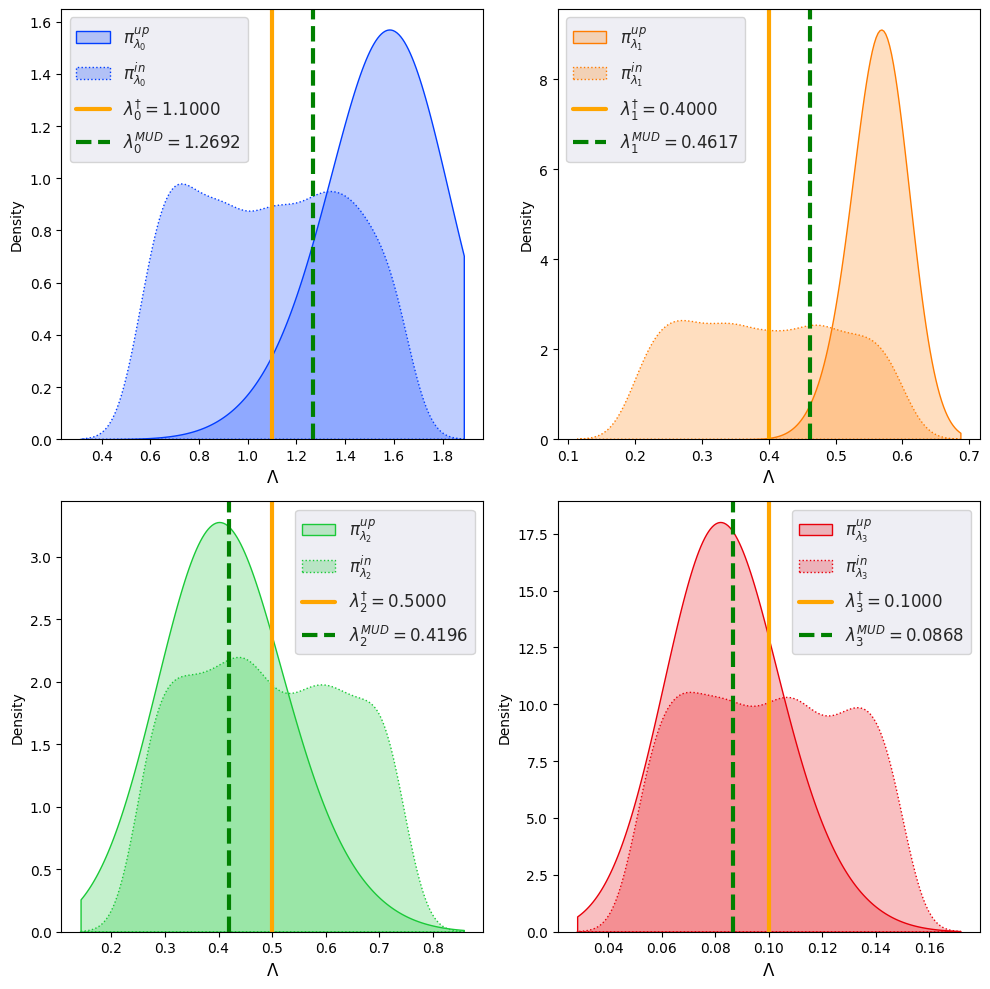

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
# sTODO: Plot in grid
for i, ax in enumerate(axes.flat):
    _, _ = seq_mud_prob.plot_param_state(param_idx=i, ax=ax, true_vals=[lv_p1])

## Second iteration

In [64]:
samples = seq_mud_prob.sample_update(1000)
args = lvm_model.mud_args(20, samples=samples)
lvm_model.x0, lvm_model.t0, args['data'].shape

on 366: /opt/conda/envs/pyDCI/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
          warnings.warn(warning_msg, ODEintWarning)


Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.7s (1527.


(array([1.81543889, 2.31701216]), 19.6875, (24, 1))

In [65]:
seq_mud_prob.update_iteration(
    args['samples'],  args['q_lam'], args['data'], args['std_dev'])

In [66]:
seq_mud_prob.state

,weight,pi_in,pi_pr,pi_obs,ratio,pi_up,lam_0,lam_1,lam_2,lam_3,...,q_lam_14,q_lam_15,q_lam_16,q_lam_17,q_lam_18,q_lam_19,q_lam_20,q_lam_21,q_lam_22,q_lam_23
0,1.0,0.0,0.0,0.0,0.0,0.0,1.255596,0.465199,0.435736,0.113526,...,7.243800,3.554716,4.043299,4.308953,2.120428,3.914539,1.478303,3.127684,1.440265,2.418491
1,1.0,0.0,0.0,0.0,0.0,0.0,1.450337,0.624944,0.654071,0.068501,...,4.388179,5.025238,1.547806,3.194625,1.403309,1.891116,2.295552,1.146043,5.169923,0.776099
2,1.0,0.0,0.0,0.0,0.0,0.0,1.184133,0.366584,0.313401,0.058889,...,11.225149,3.693543,7.903379,4.717809,4.464451,4.912749,2.688464,4.431257,1.999171,3.746534
3,1.0,0.0,0.0,0.0,0.0,0.0,1.648883,0.694155,0.448147,0.038778,...,19.941454,4.565922,4.485903,4.352406,1.827825,3.163096,1.523108,2.201375,2.146157,1.541404
4,1.0,0.0,0.0,0.0,0.0,0.0,1.787406,0.768831,0.524018,0.033928,...,12.576157,5.396727,2.201477,3.928682,1.187102,2.522090,1.470104,1.605910,3.069853,1.050550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.0,0.0,0.0,0.0,0.0,0.0,0.351705,0.035608,0.516363,0.122665,...,9.687177,5.375945,10.423415,10.706479,8.704264,20.366383,5.282763,28.085942,2.856012,27.216540
996,1.0,0.0,0.0,0.0,0.0,0.0,1.501581,0.607797,0.506324,0.095689,...,5.813675,4.486419,2.091754,3.830050,1.320520,2.748577,1.446098,1.926466,2.316450,1.408805
997,1.0,0.0,0.0,0.0,0.0,0.0,1.132188,0.415222,0.506020,0.079637,...,13.828919,4.188964,5.740397,5.321094,2.432877,4.376244,1.636694,3.145221,1.687650,2.207527
998,1.0,0.0,0.0,0.0,0.0,0.0,0.330185,0.057110,0.645921,0.130864,...,8.759923,2.021724,10.340439,3.580327,10.678237,7.245146,8.459908,13.133654,5.103007,16.388433


In [67]:
seq_mud_prob.hist['results'][-1]

nc  lam_MUD_0  lam_MUD_1  lam_MUD_2  lam_MUD_3           e_r        kl  \
0  0  1.0   1.339872   0.462634   0.527289   0.097329  1.025797e+00  0.740756   
   1  2.0   1.247935   0.448549   0.548699   0.102951  1.137257e+00  1.585525   
   2  3.0   0.878294   0.330241   0.580516   0.061060  1.175258e+00  1.755101   
   3  4.0   1.210962   0.430605   0.546281   0.132039  7.791366e-01  2.512171   
1  0  1.0   1.339872   0.462634   0.527289   0.097329  8.560197e-01  2.189741   
...   ...        ...        ...        ...        ...           ...       ...   
16 3  4.0   0.780107   0.262291   0.639530   0.134277  4.225120e-20  6.486642   
17 0  1.0   1.236024   0.472362   0.490137   0.114595  4.573207e-01  4.992192   
   1  2.0   0.970807   0.361505   0.595267   0.116942  4.860380e-13  6.302524   
   2  3.0   0.970807   0.361505   0.595267   0.116942  7.553417e-13  6.415755   
   3  4.0   0.780107   0.262291   0.639530   0.134277  4.455888e-20  6.303441   

      predict_delta  within_thresh  closest  max_kl  min_kl  action  
0  0       0.025797           True     True   False    True  UPDATE  
   1       0.137257           True    False   False   False  UPDATE  
   2       0.175258           True    False   False   False  UPDATE  
   3       0.220863           True    False   False   False  UPDATE  
1  0       0.143980           True    False   False   False  UPDATE  
...             ...            ...      ...     ...     ...     ...  
16 3       1.000000          False    False   False   False    None  
17 0       0.542679          False    False   False   False    None  
   1       1.000000          False    False   False   False    None  
   2       1.000000          False    False   False   False    None  
   3       1.000000          False    False   False   False    None  

[72 rows x 13 columns]

In [68]:
seq_mud_prob.solve()

KeyError: 25

In [ ]:
seq_mud_prob.state

,weight,pi_in,pi_pr,pi_obs,ratio,pi_up,lam_0,lam_1,lam_2,lam_3,...,ratio_nc=2,pi_up_nc=2,pi_obs_nc=3,pi_pr_nc=3,ratio_nc=3,pi_up_nc=3,pi_obs_nc=4,pi_pr_nc=4,ratio_nc=4,pi_up_nc=4
0,1.0,201.800761,0.025123,6.666293e-02,2.653442e+00,5.354667e+02,1.292184,0.525369,0.693222,0.120577,...,1.561694e-02,3.151511e+00,7.614942e-06,0.000555,1.371645e-02,2.767990e+00,1.069813e-08,0.000045,2.367171e-04,4.776970e-02
1,1.0,232.066115,0.023397,7.312083e-04,3.125171e-02,7.252462e+00,1.171971,0.466082,0.520603,0.077805,...,3.754216e-03,8.712264e-01,7.200939e-14,0.000761,9.458762e-11,2.195058e-08,1.384657e-16,0.000057,2.449445e-12,5.684333e-10
2,1.0,454.718227,0.023101,1.306577e-24,5.655825e-23,2.571807e-20,1.295831,0.504291,0.567022,0.113982,...,1.443529e-23,6.563990e-21,2.837623e-26,0.001328,2.136354e-23,9.714389e-21,1.145159e-40,0.000138,8.286996e-37,3.768248e-34
3,1.0,245.752677,0.023892,4.794653e-17,2.006820e-15,4.931814e-13,0.513201,0.184142,0.416094,0.093206,...,8.398638e-16,2.063988e-13,2.809652e-19,0.001093,2.569565e-16,6.314774e-14,9.771769e-54,0.000070,1.405650e-49,3.454424e-47
4,1.0,324.537045,0.023685,2.576442e-19,1.087783e-17,3.530259e-15,1.133828,0.416641,0.594324,0.122060,...,2.236344e-17,7.257765e-15,2.632618e-20,0.000639,4.119608e-17,1.336965e-14,9.738492e-28,0.000075,1.297258e-23,4.210082e-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.0,42.465480,0.006615,2.679815e-103,4.051038e-101,1.720293e-99,1.241045,0.429982,0.323640,0.037944,...,8.673427e-101,3.683212e-99,5.114543e-129,0.000057,9.040439e-125,3.839066e-123,2.926811e-162,0.000007,4.008123e-157,1.702069e-155
996,1.0,219.539429,0.018807,9.203410e-55,4.893536e-53,1.074324e-50,1.114554,0.333308,0.253071,0.108648,...,3.335056e-53,7.321762e-51,2.927546e-60,0.000697,4.199641e-57,9.219867e-55,7.008206e-64,0.000031,2.227005e-59,4.889154e-57
997,1.0,302.848741,0.015100,6.188491e-89,4.098317e-87,1.241170e-84,1.356421,0.487905,0.436827,0.125174,...,3.972104e-87,1.202947e-84,4.930407e-93,0.000918,5.368492e-90,1.625841e-87,3.851331e-105,0.000108,3.578082e-101,1.083618e-98
998,1.0,555.550693,0.025021,1.309720e-02,5.234415e-01,2.907983e+02,1.048356,0.353322,0.397556,0.102763,...,1.324235e-03,7.356799e-01,7.246122e-07,0.000147,4.943621e-03,2.746432e+00,1.298614e-09,0.000022,6.006409e-05,3.336865e-02


In [ ]:
seq_mud_prob.results

,nc,lam_MUD_0,lam_MUD_1,lam_MUD_2,lam_MUD_3,e_r,kl,predict_delta,within_thresh,closest,max_kl,min_kl,action
0,1.0,1.088209,0.370781,0.421613,0.102989,1.038308,1.857805,0.038308,True,True,False,True,UPDATE
1,2.0,1.457639,0.530382,0.509541,0.116540,0.593472,2.785567,0.406528,True,False,False,False,UPDATE
2,3.0,1.457639,0.530382,0.509541,0.116540,0.859414,3.720244,0.140586,True,False,True,False,UPDATE
3,4.0,1.290407,0.483452,0.459521,0.106678,0.214762,4.383639,0.785238,False,False,False,False,None


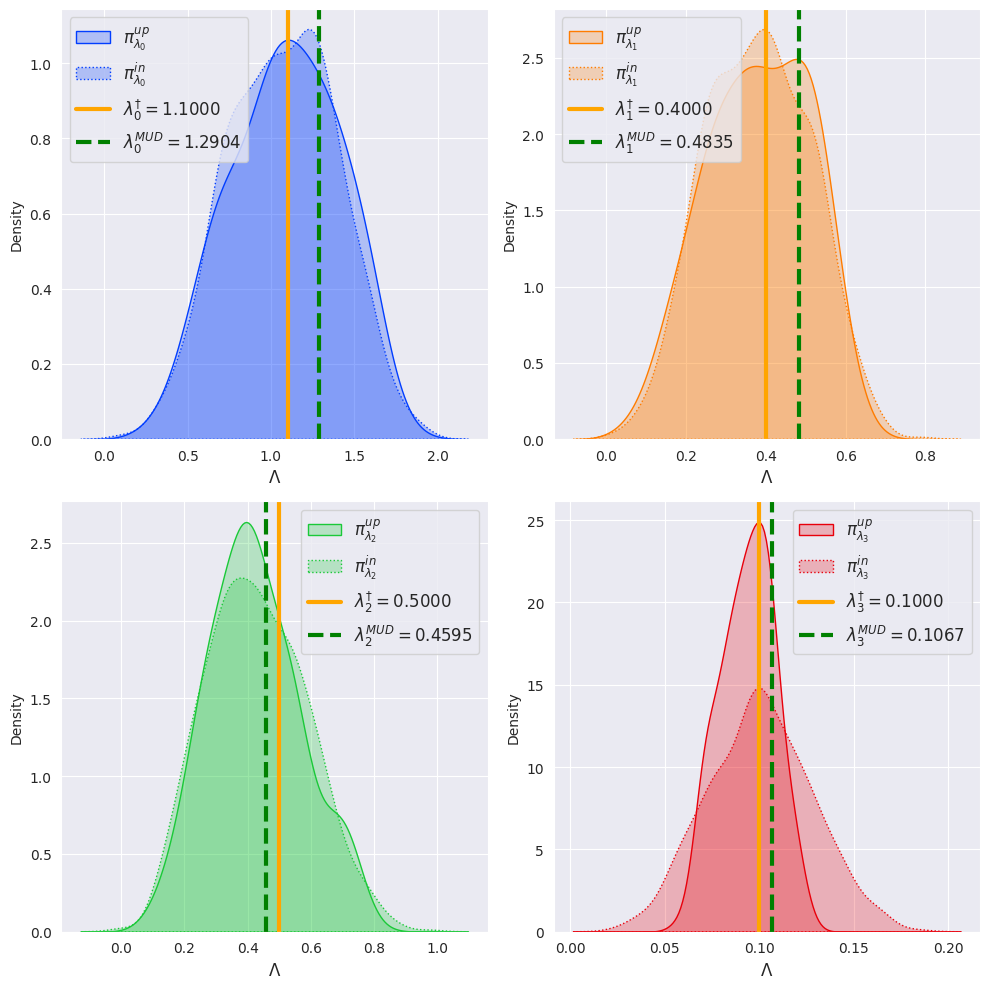

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
# sTODO: Plot in grid
for i, ax in enumerate(axes.flat):
    _, _ = seq_mud_prob.plot_param_state(param_idx=i, ax=ax, true_vals=[lv_p1])

## Third iteration

In [ ]:
samples = seq_mud_prob.sample_update(1000)
args = lvm_model.mud_args(8, samples=samples)
lvm_model.x0, lvm_model.t0, args['data'].shape

Solving model sample set: |████████████████████| 1000/1000 [100%] in 0.3s (3944.


(array([6.56539882, 4.59022384]), 7.28, (4, 1))

In [ ]:
seq_mud_prob.update_iteration(
    args['samples'],  args['q_lam'], args['data'], args['std_dev'])

In [18]:
seq_mud_prob.state

,weight,pi_in,pi_pr,pi_obs,ratio,pi_up,lam_0,lam_1,lam_2,lam_3,q_lam_0,q_lam_1,q_lam_2,q_lam_3
0,1.0,0.0,0.0,0.0,0.0,0.0,0.817557,0.317347,0.603094,0.112153,10.599994,2.862833,7.048820,4.517800
1,1.0,0.0,0.0,0.0,0.0,0.0,0.925312,0.263229,0.306520,0.095472,10.556284,2.793956,8.701429,5.823324
2,1.0,0.0,0.0,0.0,0.0,0.0,0.810669,0.284671,0.406471,0.079031,10.532781,2.931208,8.249840,4.321890
3,1.0,0.0,0.0,0.0,0.0,0.0,1.184148,0.422499,0.414295,0.093617,10.580990,2.899283,6.623442,4.626915
4,1.0,0.0,0.0,0.0,0.0,0.0,0.987065,0.337230,0.306716,0.084510,10.681199,2.947391,7.236442,5.008381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.0,0.0,0.0,0.0,0.0,0.0,0.944472,0.330036,0.474800,0.077833,10.608054,3.100777,7.974136,4.135145
996,1.0,0.0,0.0,0.0,0.0,0.0,0.860877,0.311304,0.501860,0.114873,10.495980,2.995880,6.479041,5.253781
997,1.0,0.0,0.0,0.0,0.0,0.0,1.061331,0.358807,0.795620,0.116481,10.536208,2.870291,8.319375,4.173200
998,1.0,0.0,0.0,0.0,0.0,0.0,0.755333,0.228605,0.441898,0.100823,10.733721,2.950687,8.612073,5.545329


In [19]:
seq_mud_prob.hist['results'][-1]

,nc,lam_MUD_0,lam_MUD_1,lam_MUD_2,lam_MUD_3,e_r,kl,predict_delta,within_thresh,closest,max_kl,min_kl,action
0,1.0,1.088209,0.370781,0.421613,0.102989,1.038308,1.857805,0.038308,True,True,False,True,UPDATE
1,2.0,1.457639,0.530382,0.509541,0.116540,0.593472,2.785567,0.406528,True,False,False,False,UPDATE
2,3.0,1.457639,0.530382,0.509541,0.116540,0.859414,3.720244,0.140586,True,False,True,False,UPDATE
3,4.0,1.290407,0.483452,0.459521,0.106678,0.214762,4.383639,0.785238,False,False,False,False,None


In [20]:
seq_mud_prob.max_nc = 1
seq_mud_prob.solve()

In [21]:
seq_mud_prob.state

,weight,pi_in,pi_pr,pi_obs,ratio,pi_up,lam_0,lam_1,lam_2,lam_3,q_lam_0,q_lam_1,q_lam_2,q_lam_3,q_pca_0,pi_obs_nc=1,pi_pr_nc=1,ratio_nc=1,pi_up_nc=1
0,1.0,259.134575,0.027994,7.468209e-04,2.667761e-02,6.913090e+00,0.817557,0.317347,0.603094,0.112153,10.599994,2.862833,7.048820,4.517800,3.544220,7.468209e-04,0.027994,2.667761e-02,6.913090e+00
1,1.0,331.493106,0.012872,2.561594e-108,1.990101e-106,6.597049e-104,0.925312,0.263229,0.306520,0.095472,10.556284,2.793956,8.701429,5.823324,22.217994,2.561594e-108,0.012872,1.990101e-106,6.597049e-104
2,1.0,622.328539,0.019135,2.290255e-29,1.196863e-27,7.448420e-25,0.810669,0.284671,0.406471,0.079031,10.532781,2.931208,8.249840,4.321890,11.404154,2.290255e-29,0.019135,1.196863e-27,7.448420e-25
3,1.0,1669.305695,0.030507,3.308222e-01,1.084418e+01,1.810225e+04,1.184148,0.422499,0.414295,0.093617,10.580990,2.899283,6.623442,4.626915,0.611940,3.308222e-01,0.030507,1.084418e+01,1.810225e+04
4,1.0,992.673198,0.023337,1.798586e-12,7.707039e-11,7.650571e-08,0.987065,0.337230,0.306716,0.084510,10.681199,2.947391,7.236442,5.008381,7.228427,1.798586e-12,0.023337,7.707039e-11,7.650571e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.0,266.845580,0.022133,1.300811e-15,5.877304e-14,1.568333e-11,0.944472,0.330036,0.474800,0.077833,10.608054,3.100777,7.974136,4.135145,8.167845,1.300811e-15,0.022133,5.877304e-14,1.568333e-11
996,1.0,174.605272,0.029666,8.060953e-02,2.717271e+00,4.744499e+02,0.860877,0.311304,0.501860,0.114873,10.495980,2.995880,6.479041,5.253781,1.788407,8.060953e-02,0.029666,2.717271e+00,4.744499e+02
997,1.0,58.581776,0.019104,1.252637e-29,6.556864e-28,3.841128e-26,1.061331,0.358807,0.795620,0.116481,10.536208,2.870291,8.319375,4.173200,11.456944,1.252637e-29,0.019104,6.556864e-28,3.841128e-26
998,1.0,419.861084,0.014665,3.147585e-91,2.146271e-89,9.011358e-87,0.755333,0.228605,0.441898,0.100823,10.733721,2.950687,8.612073,5.545329,20.370060,3.147585e-91,0.014665,2.146271e-89,9.011358e-87


In [22]:
seq_mud_prob.results

,nc,lam_MUD_0,lam_MUD_1,lam_MUD_2,lam_MUD_3,e_r,kl,predict_delta,within_thresh,closest,max_kl,min_kl,action
0,1.0,1.137764,0.398,0.419741,0.098148,0.952122,1.656415,0.047878,True,True,True,True,UPDATE


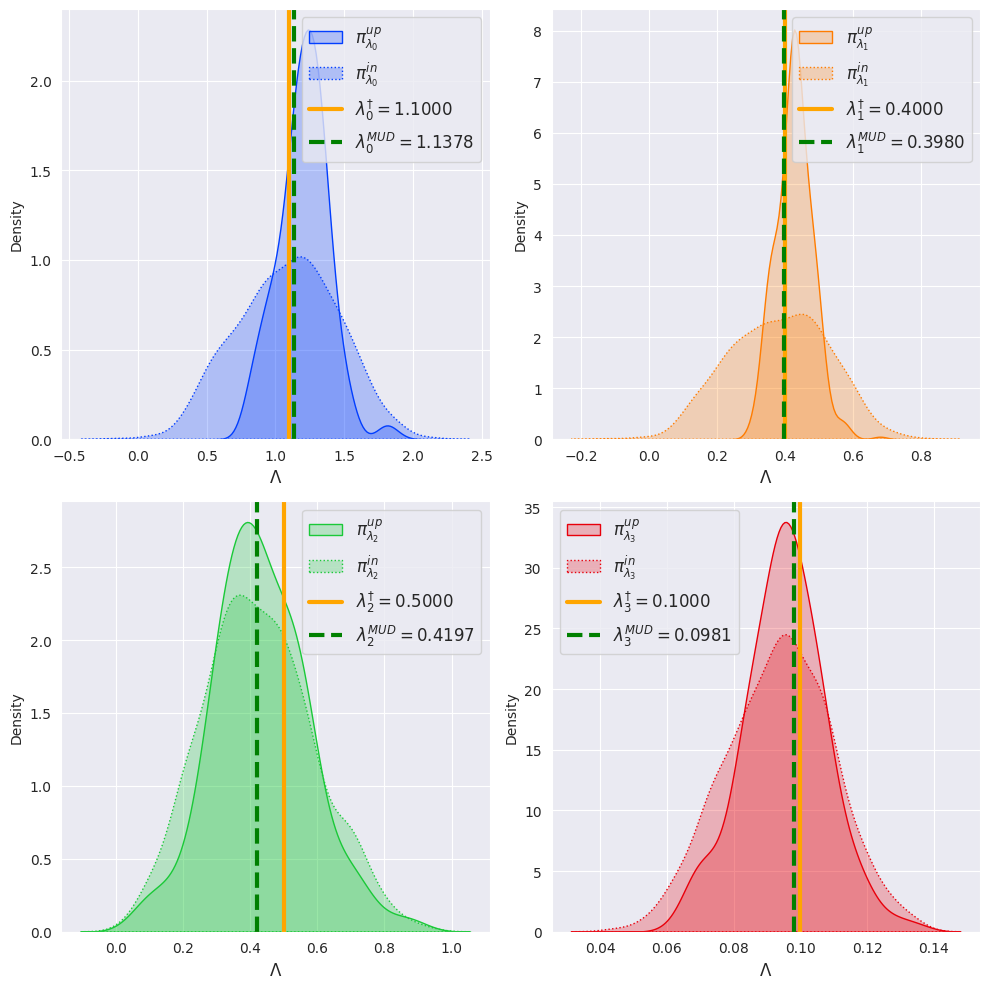

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
# sTODO: Plot in grid
for i, ax in enumerate(axes.flat):
    _, _ = seq_mud_prob.plot_param_state(param_idx=i, ax=ax, true_vals=[lv_p1])